In [22]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import glob
import random
import os
import numpy as np
from torch.utils.data import Dataset
import torch
from torch import nn
import itertools


In [23]:
def init_weights(m: nn.Module):
    classname = m.__class__.__name__
    if hasattr(m, "weight") and ("Conv" in classname or "Linear" in classname):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            nn.init.zeros_(m.bias.data)
    elif "BatchNorm2d" in classname or "InstanceNorm2d" in classname:
        # InstanceNorm2d often has affine=False by default -> no weights/bias
        if hasattr(m, "weight") and m.weight is not None:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            nn.init.zeros_(m.bias.data)

In [24]:
class ConvBlock(nn.Module):
    """
    Conv -> (Norm) -> Activation
    default: InstanceNorm + LeakyReLU for GANs
    """
    def __init__(
        self,
        in_ch: int,
        out_ch: int,
        kernel_size: int = 3,
        stride: int = 1,
        padding: int = 1,
        norm: str = "in",          # "in", "bn", or "none"
        activation: str = "relu",  # "relu", "lrelu", "gelu", or "none"
        use_bias: bool = True,
    ):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias=use_bias)

        if norm == "in":
            self.norm = nn.InstanceNorm2d(out_ch, affine=False)
        elif norm == "bn":
            self.norm = nn.BatchNorm2d(out_ch)
        elif norm == "none":
            self.norm = nn.Identity()
        else:
            raise ValueError("norm must be one of: in, bn, none")

        if activation == "relu":
            self.act = nn.ReLU(inplace=True)
        elif activation == "lrelu":
            self.act = nn.LeakyReLU(0.2, inplace=True)
        elif activation == "gelu":
            self.act = nn.GELU()
        elif activation == "none":
            self.act = nn.Identity()
        else:
            raise ValueError("activation must be one of: relu, lrelu, gelu, none")

    def forward(self, x):
        return self.act(self.norm(self.conv(x)))



In [25]:
class ResBlock(nn.Module):
    """
    ReflectionPad -> Conv -> IN -> ReLU -> ReflectionPad -> Conv -> IN + skip
    """
    def __init__(self, ch: int, use_dropout: bool = False):
        super().__init__()
        layers = [
            nn.ReflectionPad2d(1),
            nn.Conv2d(ch, ch, kernel_size=3, stride=1, padding=0, bias=True),
            nn.InstanceNorm2d(ch, affine=False),
            nn.ReLU(inplace=True),
        ]
        if use_dropout:
            layers.append(nn.Dropout(0.5))
        layers += [
            nn.ReflectionPad2d(1),
            nn.Conv2d(ch, ch, kernel_size=3, stride=1, padding=0, bias=True),
            nn.InstanceNorm2d(ch, affine=False),
        ]
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.block(x)

In [26]:
class Generator(nn.Module):
    """
    ResNet generator used in CycleGAN.
    For 256x256 images, num_res_blocks=6 is common.
    For 512x512 images, num_res_blocks=9 is common.
    """
    def __init__(self, in_ch: int = 3, out_ch: int = 3, num_res_blocks: int = 6, base_ch: int = 64):
        super().__init__()

        # Initial
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_ch, base_ch, kernel_size=7, stride=1, padding=0, bias=True),
            nn.InstanceNorm2d(base_ch, affine=False),
            nn.ReLU(inplace=True),
        ]

        # Downsample x2
        model += [
            nn.Conv2d(base_ch, base_ch * 2, kernel_size=3, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(base_ch * 2, affine=False),
            nn.ReLU(inplace=True),

            nn.Conv2d(base_ch * 2, base_ch * 4, kernel_size=3, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(base_ch * 4, affine=False),
            nn.ReLU(inplace=True),
        ]

        # Res blocks
        for _ in range(num_res_blocks):
            model.append(ResBlock(base_ch * 4, use_dropout=False))

        # Upsample x2
        model += [
            nn.ConvTranspose2d(base_ch * 4, base_ch * 2, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),
            nn.InstanceNorm2d(base_ch * 2, affine=False),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(base_ch * 2, base_ch, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),
            nn.InstanceNorm2d(base_ch, affine=False),
            nn.ReLU(inplace=True),
        ]

        # Output
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(base_ch, out_ch, kernel_size=7, stride=1, padding=0, bias=True),
            nn.Tanh(),
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)



In [27]:
class Discriminator(nn.Module):
    """
    PatchGAN discriminator used in CycleGAN.
    Outputs a (N,1,H',W') map of real/fake scores.
    """
    def __init__(self, in_ch: int = 3, base_ch: int = 64, n_layers: int = 3):
        super().__init__()

        # First layer (no norm)
        sequence = [
            nn.Conv2d(in_ch, base_ch, kernel_size=4, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
        ]

        ch = base_ch
        for i in range(1, n_layers):
            next_ch = min(ch * 2, 512)
            # stride=2 for most layers
            sequence += [
                nn.Conv2d(ch, next_ch, kernel_size=4, stride=2, padding=1, bias=True),
                nn.InstanceNorm2d(next_ch, affine=False),
                nn.LeakyReLU(0.2, inplace=True),
            ]
            ch = next_ch

        # Last conv block with stride=1 (more fine-grained patches)
        next_ch = min(ch * 2, 512)
        sequence += [
            nn.Conv2d(ch, next_ch, kernel_size=4, stride=1, padding=1, bias=True),
            nn.InstanceNorm2d(next_ch, affine=False),
            nn.LeakyReLU(0.2, inplace=True),
        ]
        ch = next_ch

        # Output layer
        sequence += [nn.Conv2d(ch, 1, kernel_size=4, stride=1, padding=1, bias=True)]

        self.model = nn.Sequential(*sequence)

    def forward(self, x):
        return self.model(x)


# -----------------------------
# Quick sanity test (optional)
# -----------------------------
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    G = Generator(3, 3, num_res_blocks=6).to(device)
    D = Discriminator(3).to(device)
    G.apply(init_weights)
    D.apply(init_weights)

    x = torch.randn(1, 3, 256, 256).to(device)
    y = G(x)
    out = D(y)
    print("G output:", y.shape)      # (1,3,256,256)
    print("D output:", out.shape)    # (1,1,H',W')

G output: torch.Size([1, 3, 256, 256])
D output: torch.Size([1, 1, 30, 30])


In [30]:
class ImageDataset(Dataset):
    def __init__(self, src_path, tgt_path, size=(256, 256)):
        # ✅ Only allow actual image extensions
        exts = ("*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp")

        self.src_images = []
        self.tgt_images = []

        for ext in exts:
            self.src_images.extend(glob.glob(os.path.join(src_path, ext)))
            self.tgt_images.extend(glob.glob(os.path.join(tgt_path, ext)))

        assert len(self.src_images) > 0, "No source images found!"
        assert len(self.tgt_images) > 0, "No target images found!"

        print(f"Loaded {len(self.src_images)} source images")
        print(f"Loaded {len(self.tgt_images)} target images")

        self.transform = transforms.Compose([
            transforms.Resize(286),
            transforms.RandomCrop(size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5],
                                 [0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return min(len(self.src_images), len(self.tgt_images))

    def __getitem__(self, idx):
        src_img = Image.open(self.src_images[idx]).convert("RGB")

        tgt_idx = random.randint(0, len(self.tgt_images) - 1)
        tgt_img = Image.open(self.tgt_images[tgt_idx]).convert("RGB")

        return self.transform(src_img), self.transform(tgt_img)

In [31]:
src_path = "/content/drive/MyDrive/paste/trainA"
tgt_path = "/content/drive/MyDrive/paste/trainB_ghibli"

dataset = ImageDataset(src_path, tgt_path)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, pin_memory=True)

Loaded 2500 source images
Loaded 2500 target images


In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
config = {
    "epochs": 30,
    "batch_size": 1,
    "lr": 2e-4,
    "decay_epoch": 15,
    "idt_coef": 0.5,
    "lambda_cycle": 10.0,
    "lambda_id": 5.0,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

device = config["device"]


In [33]:
G_A2B = Generator(3,3, num_res_blocks=6).to(device)
G_B2A = Generator(3,3, num_res_blocks=6).to(device)
D_A = Discriminator(3).to(device)
D_B = Discriminator(3).to(device)

G_A2B.apply(init_weights)
G_B2A.apply(init_weights)
D_A.apply(init_weights)
D_B.apply(init_weights)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [35]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_id = torch.nn.L1Loss()

optimizer_G = torch.optim.Adam(itertools.chain(G_A2B.parameters(), G_B2A.parameters()),
                               lr=config["lr"], betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(itertools.chain(D_A.parameters(), D_B.parameters()),
                               lr=config["lr"], betas=(0.5,0.999))


In [36]:
class ReplayBuffer:
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        out = []
        for element in data:
            element = torch.unsqueeze(element.data, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                out.append(element)
            else:
                if random.random() > 0.5:
                    idx = random.randint(0, self.max_size-1)
                    tmp = self.data[idx].clone()
                    self.data[idx] = element
                    out.append(tmp)
                else:
                    out.append(element)
        return torch.cat(out, 0)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()


In [37]:
import tqdm

lambda_cycle = 10.0
lambda_id = 5.0   # usually 0.5 * lambda_cycle

for epoch in range(config["epochs"]):
    pbar = tqdm.tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{config['epochs']}")

    for i, (real_A, real_B) in pbar:
        real_A = real_A.to(device)
        real_B = real_B.to(device)

        # ✅ dynamic patch labels (no hardcoding 30x30)
        with torch.no_grad():
            valid_A = torch.ones_like(D_A(real_A), device=device)
            fake_A_lbl = torch.zeros_like(D_A(real_A), device=device)
            valid_B = torch.ones_like(D_B(real_B), device=device)
            fake_B_lbl = torch.zeros_like(D_B(real_B), device=device)

        # ------------------
        #  Train Generators
        # ------------------
        optimizer_G.zero_grad()

        # Identity loss
        loss_id_A = criterion_id(G_B2A(real_A), real_A) * lambda_id
        loss_id_B = criterion_id(G_A2B(real_B), real_B) * lambda_id

        # GAN loss
        fake_B = G_A2B(real_A)
        fake_A = G_B2A(real_B)
        loss_GAN_A2B = criterion_GAN(D_B(fake_B), valid_B)
        loss_GAN_B2A = criterion_GAN(D_A(fake_A), valid_A)

        # Cycle loss
        recov_A = G_B2A(fake_B)
        recov_B = G_A2B(fake_A)
        loss_cycle_A = criterion_cycle(recov_A, real_A) * lambda_cycle
        loss_cycle_B = criterion_cycle(recov_B, real_B) * lambda_cycle

        # Total generator loss
        loss_G = loss_GAN_A2B + loss_GAN_B2A + loss_cycle_A + loss_cycle_B + loss_id_A + loss_id_B
        loss_G.backward()
        optimizer_G.step()

        # -----------------------
        #  Train Discriminators
        # -----------------------
        optimizer_D.zero_grad()

        # Discriminator A
        fake_A_ = fake_A_buffer.push_and_pop(fake_A.detach())
        loss_D_A = 0.5 * (criterion_GAN(D_A(real_A), valid_A) + criterion_GAN(D_A(fake_A_), fake_A_lbl))

        # Discriminator B
        fake_B_ = fake_B_buffer.push_and_pop(fake_B.detach())
        loss_D_B = 0.5 * (criterion_GAN(D_B(real_B), valid_B) + criterion_GAN(D_B(fake_B_), fake_B_lbl))

        loss_D = loss_D_A + loss_D_B
        loss_D.backward()
        optimizer_D.step()

        # Live progress
        if i % 50 == 0:
            pbar.set_postfix(G=f"{loss_G.item():.3f}", D=f"{loss_D.item():.3f}")

    print(f"Epoch {epoch+1} done | Loss_G: {loss_G.item():.4f} | Loss_D: {loss_D.item():.4f}")


Epoch 1/30: 100%|██████████| 2500/2500 [04:42<00:00,  8.85it/s, D=0.511, G=8.000]


Epoch 1 done | Loss_G: 4.7669 | Loss_D: 0.3388


Epoch 2/30: 100%|██████████| 2500/2500 [04:29<00:00,  9.27it/s, D=0.764, G=4.937]


Epoch 2 done | Loss_G: 5.6141 | Loss_D: 0.4056


Epoch 3/30: 100%|██████████| 2500/2500 [04:28<00:00,  9.31it/s, D=0.347, G=4.629]


Epoch 3 done | Loss_G: 6.2955 | Loss_D: 0.4872


Epoch 4/30: 100%|██████████| 2500/2500 [04:31<00:00,  9.20it/s, D=0.255, G=5.587]


Epoch 4 done | Loss_G: 6.4145 | Loss_D: 0.3175


Epoch 5/30: 100%|██████████| 2500/2500 [04:30<00:00,  9.25it/s, D=0.415, G=7.051]


Epoch 5 done | Loss_G: 5.6861 | Loss_D: 0.3149


Epoch 6/30: 100%|██████████| 2500/2500 [04:29<00:00,  9.28it/s, D=0.516, G=3.800]


Epoch 6 done | Loss_G: 6.6229 | Loss_D: 0.3892


Epoch 7/30: 100%|██████████| 2500/2500 [04:29<00:00,  9.26it/s, D=0.351, G=4.294]


Epoch 7 done | Loss_G: 5.4516 | Loss_D: 0.4721


Epoch 8/30: 100%|██████████| 2500/2500 [04:29<00:00,  9.28it/s, D=0.496, G=4.962]


Epoch 8 done | Loss_G: 6.3590 | Loss_D: 0.7221


Epoch 9/30: 100%|██████████| 2500/2500 [04:29<00:00,  9.29it/s, D=0.239, G=5.380]


Epoch 9 done | Loss_G: 3.3178 | Loss_D: 0.4832


Epoch 10/30: 100%|██████████| 2500/2500 [04:29<00:00,  9.26it/s, D=0.413, G=4.507]


Epoch 10 done | Loss_G: 13.1265 | Loss_D: 0.5928


Epoch 11/30: 100%|██████████| 2500/2500 [04:30<00:00,  9.25it/s, D=0.415, G=4.203]


Epoch 11 done | Loss_G: 3.1103 | Loss_D: 0.2438


Epoch 12/30: 100%|██████████| 2500/2500 [04:29<00:00,  9.27it/s, D=0.709, G=3.810]


Epoch 12 done | Loss_G: 4.1603 | Loss_D: 0.3571


Epoch 13/30: 100%|██████████| 2500/2500 [04:30<00:00,  9.24it/s, D=0.216, G=4.472]


Epoch 13 done | Loss_G: 4.9786 | Loss_D: 0.4065


Epoch 14/30: 100%|██████████| 2500/2500 [04:29<00:00,  9.28it/s, D=0.131, G=4.417]


Epoch 14 done | Loss_G: 4.1874 | Loss_D: 0.4851


Epoch 15/30: 100%|██████████| 2500/2500 [04:29<00:00,  9.28it/s, D=0.193, G=3.738]


Epoch 15 done | Loss_G: 4.6446 | Loss_D: 0.2546


Epoch 16/30: 100%|██████████| 2500/2500 [04:28<00:00,  9.31it/s, D=0.377, G=3.525]


Epoch 16 done | Loss_G: 6.0431 | Loss_D: 0.3932


Epoch 17/30: 100%|██████████| 2500/2500 [04:28<00:00,  9.30it/s, D=0.216, G=5.520]


Epoch 17 done | Loss_G: 4.3564 | Loss_D: 0.5553


Epoch 18/30: 100%|██████████| 2500/2500 [04:29<00:00,  9.28it/s, D=0.643, G=3.593]


Epoch 18 done | Loss_G: 5.5220 | Loss_D: 0.2444


Epoch 19/30: 100%|██████████| 2500/2500 [04:29<00:00,  9.27it/s, D=0.492, G=3.342]


Epoch 19 done | Loss_G: 3.3442 | Loss_D: 0.5929


Epoch 20/30: 100%|██████████| 2500/2500 [04:29<00:00,  9.28it/s, D=0.438, G=5.500]


Epoch 20 done | Loss_G: 3.2663 | Loss_D: 0.5162


Epoch 21/30: 100%|██████████| 2500/2500 [04:29<00:00,  9.28it/s, D=0.117, G=5.886]


Epoch 21 done | Loss_G: 3.8697 | Loss_D: 0.4915


Epoch 22/30: 100%|██████████| 2500/2500 [04:30<00:00,  9.25it/s, D=0.499, G=3.438]


Epoch 22 done | Loss_G: 3.2914 | Loss_D: 0.2832


Epoch 23/30: 100%|██████████| 2500/2500 [04:28<00:00,  9.29it/s, D=0.490, G=6.648]


Epoch 23 done | Loss_G: 5.2678 | Loss_D: 0.3602


Epoch 24/30: 100%|██████████| 2500/2500 [04:29<00:00,  9.28it/s, D=0.349, G=3.961]


Epoch 24 done | Loss_G: 5.5436 | Loss_D: 0.2242


Epoch 25/30: 100%|██████████| 2500/2500 [04:30<00:00,  9.26it/s, D=0.289, G=3.710]


Epoch 25 done | Loss_G: 2.5979 | Loss_D: 0.4430


Epoch 26/30: 100%|██████████| 2500/2500 [04:29<00:00,  9.27it/s, D=0.404, G=3.991]


Epoch 26 done | Loss_G: 6.5442 | Loss_D: 0.1839


Epoch 27/30: 100%|██████████| 2500/2500 [04:29<00:00,  9.28it/s, D=0.356, G=8.877]


Epoch 27 done | Loss_G: 3.7233 | Loss_D: 0.2480


Epoch 28/30: 100%|██████████| 2500/2500 [04:28<00:00,  9.30it/s, D=0.301, G=5.945]


Epoch 28 done | Loss_G: 6.4803 | Loss_D: 0.4280


Epoch 29/30: 100%|██████████| 2500/2500 [04:29<00:00,  9.29it/s, D=0.552, G=3.892]


Epoch 29 done | Loss_G: 3.4296 | Loss_D: 0.5142


Epoch 30/30: 100%|██████████| 2500/2500 [04:30<00:00,  9.23it/s, D=0.239, G=4.563]

Epoch 30 done | Loss_G: 5.5589 | Loss_D: 0.5458


In [38]:
torch.save(G_A2B.state_dict(), "G_A2B.pth")
torch.save(G_B2A.state_dict(), "G_B2A.pth")


In [44]:
import os
print("Drive mounted?", os.path.exists("/content/drive/MyDrive"))
print("paste folder exists?", os.path.exists("/content/drive/MyDrive/paste"))


Drive mounted? True
paste folder exists? True


In [45]:
!ls -lah /content/drive/MyDrive


total 300K
drwx------ 2 root root 4.0K Nov  7 10:06  analytics
drwx------ 2 root root 4.0K Sep  3 23:11  Blogs
drwx------ 2 root root 4.0K Sep  3 22:58  Certifications
drwx------ 5 root root 4.0K Oct 16  2024 'Colab Notebooks'
-rw------- 1 root root  175 Nov  8  2024 'Copy of Freebie: Resume Templates (2023) ✅.gdoc'
-rw------- 1 root root 1.2K Aug  4  2024  countw.py
-rw------- 1 root root 1.5K Aug  4  2024  last.py
-rw------- 1 root root  175 Aug  6 04:44 'Monthly sales template.gsheet'
-rw------- 1 root root 2.5K Aug  4  2024  movie.py
drwx------ 4 root root 4.0K Jan 18 20:23  paste
drwx------ 3 root root 4.0K Jun 25  2024  port
-rw------- 1 root root   82 Aug  4  2024  reverse.py
-rw------- 1 root root  244 Aug  4  2024  sumoffib.py
-rw------- 1 root root 268K Nov 26  2024  SwethaN.pdf


In [46]:
!ls -lah /content


total 60M
drwxr-xr-x 1 root root 4.0K Jan 19 03:50 .
drwxr-xr-x 1 root root 4.0K Jan 18 22:27 ..
drwxr-xr-x 4 root root 4.0K Dec  9 14:41 .config
drwx------ 5 root root 4.0K Jan 18 22:31 drive
-rw-r--r-- 1 root root  30M Jan 19 03:50 G_A2B.pth
-rw-r--r-- 1 root root  30M Jan 19 03:50 G_B2A.pth
drwxr-xr-x 1 root root 4.0K Dec  9 14:42 sample_data


In [56]:

MODEL_DIR = "/content/drive/MyDrive/paste/models/ghibli"
os.makedirs(MODEL_DIR, exist_ok=True)


In [57]:
!mv /content/G_A2B.pth /content/drive/MyDrive/paste/models/ghibli/G_A2B.pth
!mv /content/G_B2A.pth /content/drive/MyDrive/paste/models/ghibli/G_B2A.pth


In [59]:
!ls -lah /content/drive/MyDrive/paste/models/ghibli


total 60M
-rw-------+ 1 root root 30M Jan 19 03:50 G_A2B.pth
-rw-------+ 1 root root 30M Jan 19 03:50 G_B2A.pth


In [61]:
MODEL_PATH = "/content/drive/MyDrive/paste/models/ghibli/G_A2B.pth"

G_A2B.load_state_dict(
    torch.load(MODEL_PATH, map_location=device)
)
G_A2B.eval()


Generator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d

In [66]:
device = "cuda" if torch.cuda.is_available() else "cpu"

G_A2B = Generator(3, 3, num_res_blocks=6).to(device)

G_A2B.load_state_dict(
    torch.load("/content/drive/MyDrive/paste/models/ghibli/G_A2B.pth", map_location=device)
)

G_A2B.eval()

print("✅ G_A2B model loaded successfully")


✅ G_A2B model loaded successfully


In [67]:
import requests, io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
])

def tensor_to_pil(t):
    t = t.squeeze(0).detach().cpu()
    t = (t * 0.5 + 0.5).clamp(0, 1)
    arr = (t.permute(1,2,0).numpy() * 255).astype(np.uint8)
    return Image.fromarray(arr)


In [69]:
def stylize_from_url(image_url):
    # download image
    r = requests.get(image_url, timeout=30)
    r.raise_for_status()
    img = Image.open(io.BytesIO(r.content)).convert("RGB")

    # preprocess
    x = preprocess(img).unsqueeze(0).to(device)

    # inference
    with torch.no_grad():
        y = G_A2B(x)

    out_img = tensor_to_pil(y)

    # display side by side
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(out_img)
    plt.title("Ghibli")
    plt.axis("off")

    plt.show()

    return img, out_img


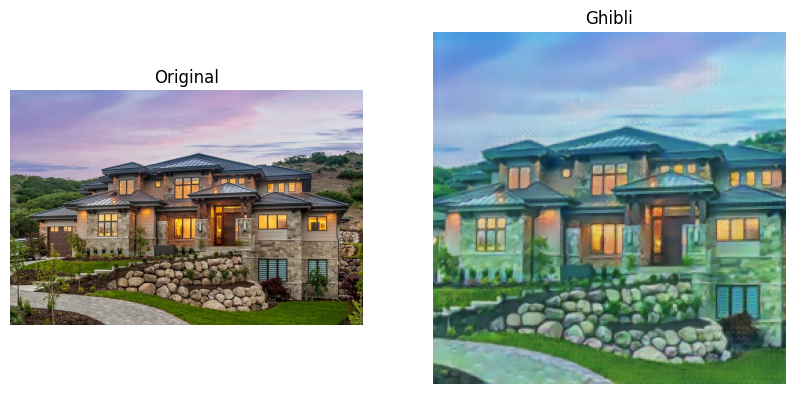

(<PIL.Image.Image image mode=RGB size=1200x801>,
 <PIL.Image.Image image mode=RGB size=256x256>)

In [87]:
stylize_from_url(
    "https://assets.architecturaldesigns.com/cdn-cgi/image/width=3840,quality=75,format=auto,slow-connection-quality=50/plan_assets/325000035/original/290101IY_01_1693600745.jpg"
)


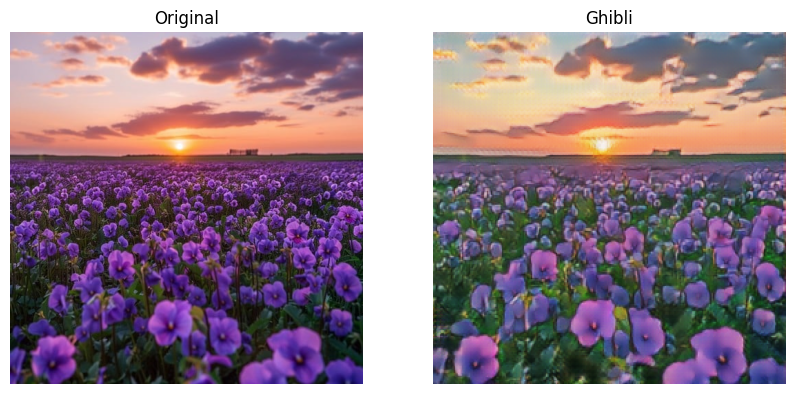

(<PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=256x256>)

In [72]:
stylize_from_url(
    "https://images.stockcake.com/public/a/0/d/a0df3fa1-fd8f-4bd0-8c21-3b6484879741_large/sunset-flower-field-stockcake.jpg"
)

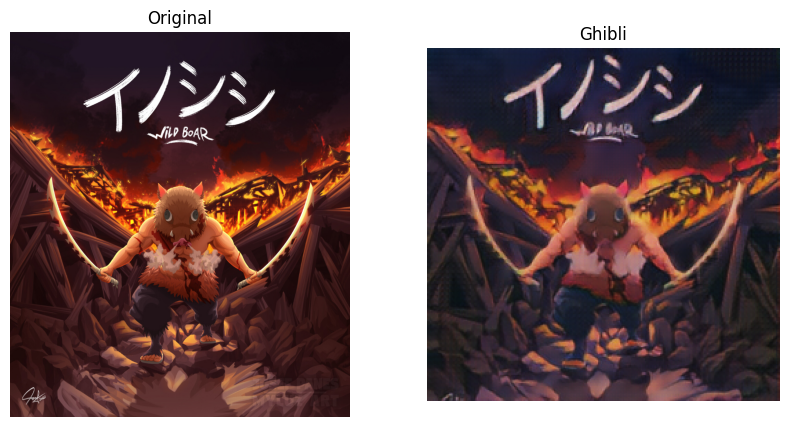

(<PIL.Image.Image image mode=RGB size=1324x1500>,
 <PIL.Image.Image image mode=RGB size=256x256>)

In [85]:
stylize_from_url("https://cdna.artstation.com/p/assets/images/images/047/290/974/large/josef-panes-inosuke-fan-art-4-watermarked.jpg?1647255233")